# Introduction
## Feature Engineering: Uncensoring & Cyclicality
**Objective:** Prepare the dataset for the Global LightGBM model.

We will address two major issues:
1.  **Censoring:** We will estimate "True Demand" for stockout days.
2.  **Seasonality:** We will transform dates into cyclical sin/cos features to preserve time continuity.

### Step 1 Setup and Imports:
Import our custom modules from the `src` folder.

In [1]:
import sys
import pandas as pd
sys.path.append('..') # Allow importing from src

from src.data.uncensor import estimate_true_demand
from src.features.cyclical import encode_cyclical_date_features

df = pd.read_csv('../data/raw/synthetic_sales.csv')
df.head()

,date,product_id,inventory_morning,qty_sold,true_demand_hidden,is_stockout,store_traffic
0,2023-01-01,1,33,33,33,0,571
1,2023-01-02,1,19,19,20,1,966
2,2023-01-03,1,18,18,25,1,872
3,2023-01-04,1,34,33,33,0,649
4,2023-01-05,1,23,23,26,1,913


### Step 2 Applying Uncensoring Logic:
We apply the `estimate_true_demand` function. 
* **Logic:** If `is_stockout` is True, we replace `qty_sold` with an estimated value (Sales + Potential).

In [2]:
# Apply the logic
df_processed = estimate_true_demand(df)

# Check the results
sample_stockout = df_processed[df_processed['is_stockout'] == 1].iloc[0]
print(f"Recorded Sales: {sample_stockout['qty_sold']}")
print(f"Adjusted Target: {sample_stockout['adjusted_demand_target']:.2f}")

Recorded Sales: 19
Adjusted Target: 46.52


### Step 3 Cyclical Date Encoding:
Machine Learning models don't understand that "Month 12" is next to "Month 1". 
We transform the date into 2D coordinates (Sin/Cos) to represent this circle.

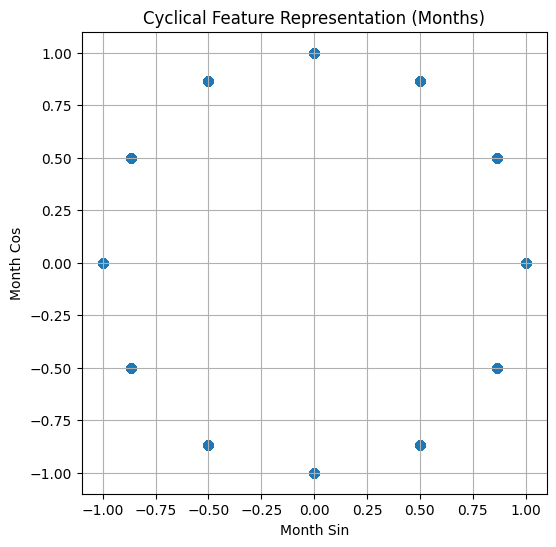

In [3]:
df_features = encode_cyclical_date_features(df_processed, date_col='date')

# Visualize the circle
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(df_features['month_sin'], df_features['month_cos'])
plt.title("Cyclical Feature Representation (Months)")
plt.xlabel("Month Sin")
plt.ylabel("Month Cos")
plt.grid()
plt.show()

### Step 4 Save Processed Data:
Save the feature-rich dataset for modeling.

In [4]:
# Save to processed folder
df_features.to_csv('../data/processed/training_data.csv', index=False)
print("Features engineered and saved to ../data/processed/training_data.csv")

Features engineered and saved to ../data/processed/training_data.csv


### Conclusion
We have successfully engineered the dataset:
* **Target Variable:** We now have `adjusted_demand_target` which approximates true customer intent.
* **Time Features:** We have `month_sin` and `month_cos` to capture seasonality correctly.
* **Next Step:** We are ready to train the Global LightGBM model.